# 90th and 95th Percentile- TMAX 


### Inserting all required libraries

In [1]:
import requests 
import numpy as np
import pandas as pd
from datetime import datetime
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.axes as ax

### Gettign data through API request

In [2]:
api = 'http://api.cal-adapt.org/api'
headers = {'ContentType': 'json'}

# Your point of interest
point = 'POINT(-118.3089 34.1808)'

# Name of boundary layer in API
resource = 'locagrid'

# Request url
url = api + '/' + resource + '/'
# Request params to find intersecting polygon
params = {'intersects': point, 'srs': 4326, 'simplify': .0001, 'precision': 4}
ref = ''
location = ''

# Get geometry
response = requests.get(url, params=params, headers=headers)
if response.ok:
    data = response.json()
    print(data)
    feature = data['features'][0]
    if (feature):
        ref = '/api/%s/%s/' % (resource, feature['id'])
        #location = feature['properties']['name']
        print('ref =', ref)
        #print('location =', location)
    else:
        print('Did not find any polygons that intersect your point')
params = {'ref': ref, 'stat': 'mean'}
#print(data)

{'count': 1, 'crs': {'type': 'name', 'properties': {'name': 'urn:ogc:def:crs:EPSG::4326'}}, 'features': [{'geometry': {'type': 'Polygon', 'coordinates': [[[-118.3125, 34.1875], [-118.25, 34.1875], [-118.25, 34.125], [-118.3125, 34.125], [-118.3125, 34.1875]]]}, 'type': 'Feature', 'properties': {}, 'id': 47408}], 'next': None, 'type': 'FeatureCollection', 'previous': None}
ref = /api/locagrid/47408/


In [3]:
# Cal-Adapt API
api = 'http://api.cal-adapt.org/api'

# Request header
headers = {'ContentType': 'json'}

def celsius_to_F(val):
    return val * 9/5 + 32

def kelvin_to_C(val):
    return  val - 273.15

def process_daily_data(slug, params):
    # Make request
    url = api + '/series/' + slug + '/rasters/'
    response = requests.get(url, params=params)
    
    # Get data
    if response.ok:
        #print('Processing:', slug)
        json = response.json()
        data = json['results'][0]
        # Multiband raster data is returned by the API as a 3D array having a shape like (233376, 1, 1)
        # Flatten the 3D array into a 1D array
        values_arr = np.array(data['image'])
        values_arr = values_arr.flatten()# Get total number of values -> number of days
            #dft = pd.DataFrame(data['image'])
            #print(dft.head(10))
            #length = len(dft)
        length = len(values_arr)
        # Get start date of timeseries
        start_date = datetime.strptime(data['event'], '%Y-%m-%d')
        
        # Create new pandas dataframe and map each value in list to a date index
        df = pd.DataFrame(
            values_arr,
            index= pd.date_range(start_date, freq='1D', periods=length),
            columns=['value']
        )

        # Convert units to Fahrenheit
        units = data['units']
        #if units == 'C':
            #df.value = df.value.apply(lambda x: celsius_to_F(x))
        if units == 'K':
            df.value = df.value.apply(lambda x: kelvin_to_C(x))
        else:
            pass
            
        # Add slug as a column
        df['slug'] = slug  

    else:
        print('Failed to download:', slug)
            
    # Combine all the dataframes into one and return
    return df

### Change the below parameters as required

In [4]:
def get_projections():
    # Create an empty list to hold dataframes
    df_list = []

    # Make a combined list of GCMs, scenarios, climate variables for looping
    climvar = ['tasmax']
    period = ['day']
    models = ['CanESM2', 'CNRM-CM5', 'HadGEM2-ES', 'MIROC5']
    scenarios = ['historical','rcp85', 'rcp45']
    zipped = itertools.product(climvar, period, models, scenarios)
    
    # Request parameters
    params = {'ref': ref, 'stat': 'mean'}

    # Loop through zipped
    for item in zipped:
        # Create slug
        slug = '_'.join(item)
        df = process_daily_data(slug, params)
        df_list.append(df)
            
    # Combine all the dataframes into one and return
    return pd.concat(df_list)

### Visulizing the data set

In [5]:
projectedDF = get_projections()
projectedDF.head(10)

,value,slug
1950-01-01,16.568506,tasmax_day_CanESM2_historical
1950-01-02,21.465723,tasmax_day_CanESM2_historical
1950-01-03,25.958093,tasmax_day_CanESM2_historical
1950-01-04,28.902765,tasmax_day_CanESM2_historical
1950-01-05,25.877649,tasmax_day_CanESM2_historical
1950-01-06,20.492914,tasmax_day_CanESM2_historical
1950-01-07,22.721918,tasmax_day_CanESM2_historical
1950-01-08,22.059717,tasmax_day_CanESM2_historical
1950-01-09,23.046777,tasmax_day_CanESM2_historical
1950-01-10,21.718042,tasmax_day_CanESM2_historical


In [6]:
# Keep only required parameters in slug
temp = projectedDF['slug'].str.split('_', expand=True)[2] + str("_")+projectedDF['slug'].str.split('_', expand=True)[3]
projectedDF['test'] = temp
projectedDF.index.name = 'Date'

projectedDF.drop(columns= 'slug', inplace = True)
projectedDF.head()

,value,test
Date,,
1950-01-01,16.568506,CanESM2_historical
1950-01-02,21.465723,CanESM2_historical
1950-01-03,25.958093,CanESM2_historical
1950-01-04,28.902765,CanESM2_historical
1950-01-05,25.877649,CanESM2_historical


In [7]:
projectedDF.head()

,value,test
Date,,
1950-01-01,16.568506,CanESM2_historical
1950-01-02,21.465723,CanESM2_historical
1950-01-03,25.958093,CanESM2_historical
1950-01-04,28.902765,CanESM2_historical
1950-01-05,25.877649,CanESM2_historical


### Using pivot tables to split column 'test' values to rows

In [8]:
projectedDF = projectedDF.pivot_table( values = 'value', index = 'Date', columns = 'test')

In [9]:
#projectedDF = projectedDF.loc[:'2050-12-31']
#projectedDF.head()

### Combining historical & rcp 4.5 AND historical & rcp 8.5

In [10]:
projectedDF['CNRM-CM5_rcp45'].fillna(projectedDF['CNRM-CM5_historical'], inplace=True)
projectedDF['CNRM-CM5_rcp85'].fillna(projectedDF['CNRM-CM5_historical'], inplace=True)
del projectedDF['CNRM-CM5_historical']

projectedDF['CanESM2_rcp45'].fillna(projectedDF['CanESM2_historical'], inplace=True)
projectedDF['CanESM2_rcp85'].fillna(projectedDF['CanESM2_historical'], inplace=True)
del projectedDF['CanESM2_historical']

projectedDF['HadGEM2-ES_rcp45'].fillna(projectedDF['HadGEM2-ES_historical'], inplace=True)
projectedDF['HadGEM2-ES_rcp85'].fillna(projectedDF['HadGEM2-ES_historical'], inplace=True)
del projectedDF['HadGEM2-ES_historical'] 

projectedDF['MIROC5_rcp45'].fillna(projectedDF['MIROC5_historical'], inplace=True)
projectedDF['MIROC5_rcp85'].fillna(projectedDF['MIROC5_historical'], inplace=True)
del projectedDF['MIROC5_historical']             
                
#df.columns = 'File heat Observations'.split()

In [11]:
# Visulazing first few rows 
projectedDF.head()

test,CNRM-CM5_rcp45,CNRM-CM5_rcp85,CanESM2_rcp45,CanESM2_rcp85,HadGEM2-ES_rcp45,HadGEM2-ES_rcp85,MIROC5_rcp45,MIROC5_rcp85
Date,,,,,,,,
1950-01-01,21.505518,21.505518,16.568506,16.568506,17.160547,17.160547,25.320825,25.320825
1950-01-02,20.837213,20.837213,21.465723,21.465723,20.333276,20.333276,24.488977,24.488977
1950-01-03,16.950952,16.950952,25.958093,25.958093,19.518793,19.518793,21.193018,21.193018
1950-01-04,18.520013,18.520013,28.902765,28.902765,18.017725,18.017725,24.452905,24.452905
1950-01-05,19.739496,19.739496,25.877649,25.877649,17.364526,17.364526,24.792169,24.792169


In [12]:
# Visulazing last few rows in the dataset
projectedDF.tail()

test,CNRM-CM5_rcp45,CNRM-CM5_rcp85,CanESM2_rcp45,CanESM2_rcp85,HadGEM2-ES_rcp45,HadGEM2-ES_rcp85,MIROC5_rcp45,MIROC5_rcp85
Date,,,,,,,,
2100-12-27,23.946893,27.040002,22.470880,23.521753,NaN,NaN,NaN,NaN
2100-12-28,23.426233,26.878503,21.761865,21.426752,NaN,NaN,NaN,NaN
2100-12-29,18.291315,26.584100,26.176599,23.945673,NaN,NaN,NaN,NaN
2100-12-30,20.812097,22.060693,27.366998,23.336511,NaN,NaN,NaN,NaN
2100-12-31,22.391199,25.400262,28.226251,22.811792,NaN,NaN,NaN,NaN


### Global settings for all graphs in this notebook

In [36]:
plt.rcParams['lines.linewidth'] = 2
plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = (13.0, 10.0)

### Calculating 90th and 95th percentile based upon 30 year window (CNRM-CM5)

In [37]:
cnrm45_quant90 = projectedDF['CNRM-CM5_rcp45'].rolling(10957).quantile(.90, interpolation='lower')
cnrm45_quant95 = projectedDF['CNRM-CM5_rcp45'].rolling(10957).quantile(.95, interpolation='lower')
cnrm45_quant50 = projectedDF['CNRM-CM5_rcp45'].rolling(10957).quantile(.50, interpolation='lower')
cnrm45_mean = projectedDF['CNRM-CM5_rcp45'].rolling(10957).mean()
cnrm85_quant90 = projectedDF['CNRM-CM5_rcp85'].rolling(10957).quantile(.90, interpolation='lower')
cnrm85_quant95 = projectedDF['CNRM-CM5_rcp85'].rolling(10957).quantile(.95, interpolation='lower')
cnrm85_quant50 = projectedDF['CNRM-CM5_rcp85'].rolling(10957).quantile(.50, interpolation='lower')
cnrm85_mean = projectedDF['CNRM-CM5_rcp85'].rolling(10957).mean()


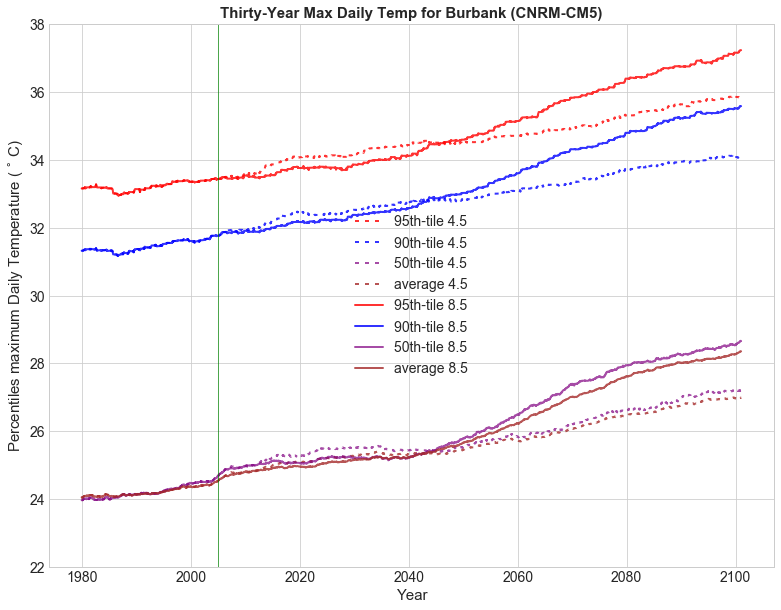

In [38]:
plt.plot(projectedDF.index, cnrm45_quant95, color = 'r', ls = 'dashed', dashes=(2, 3), alpha = 0.8, label = '95th-tile 4.5')
plt.plot(projectedDF.index, cnrm45_quant90, color = 'b', ls = 'dashed', dashes=(2, 3), alpha = 0.8, label = '90th-tile 4.5')
plt.plot(projectedDF.index, cnrm45_quant50, color = 'purple', ls = 'dashed', dashes=(2, 3), alpha = 0.7, label = '50th-tile 4.5')
plt.plot(projectedDF.index, cnrm45_mean, color = 'brown', alpha = 0.8, ls = 'dashed', dashes=(2, 3), label = 'average 4.5')
plt.plot(projectedDF.index, cnrm85_quant95, color = 'r', ls = 'solid', alpha = 0.8, label = '95th-tile 8.5')
plt.plot(projectedDF.index, cnrm85_quant90, color = 'b', ls = 'solid', alpha = 0.8, label = '90th-tile 8.5')
plt.plot(projectedDF.index, cnrm85_quant50, color = 'purple', ls = 'solid', alpha = 0.7, label = '50th-tile 8.5')
plt.plot(projectedDF.index, cnrm85_mean, color = 'brown', alpha = 0.8, ls = 'solid',  label = 'average 8.5')


plt.xlabel('Year', fontsize = 15)
plt.ylabel('Percentiles maximum Daily Temperature ( $^{\circ}$ C)', fontsize = 15)
plt.title('Thirty-Year Max Daily Temp for Burbank (CNRM-CM5)', fontsize = 15, weight = 'bold')
#plt.text(723999, 30.3, 'Historical Simulations', fontsize = 13)
#plt.text(739999, 30.3, 'Projections', fontsize = 13)
plt.legend()
plt.style.use('seaborn-whitegrid')
axes = plt.gca()
axes.set_ylim([22,38])
#plt.rcParams['figure.figsize'] = [13, 18]
plt.axvline(x= '2005', alpha = 0.7, color = 'g', linewidth = 1.0)
plt.savefig('test1.pdf', bbox_inches='tight')
plt.show()


### CanESM2

In [39]:
canesm45_quant90 = projectedDF['CanESM2_rcp45'].rolling(10957).quantile(.90, interpolation='lower')
canesm45_quant95 = projectedDF['CanESM2_rcp45'].rolling(10957).quantile(.95, interpolation='lower')
canesm85_quant90 = projectedDF['CanESM2_rcp85'].rolling(10957).quantile(.90, interpolation='lower')
canesm85_quant95 = projectedDF['CanESM2_rcp85'].rolling(10957).quantile(.95, interpolation='lower')

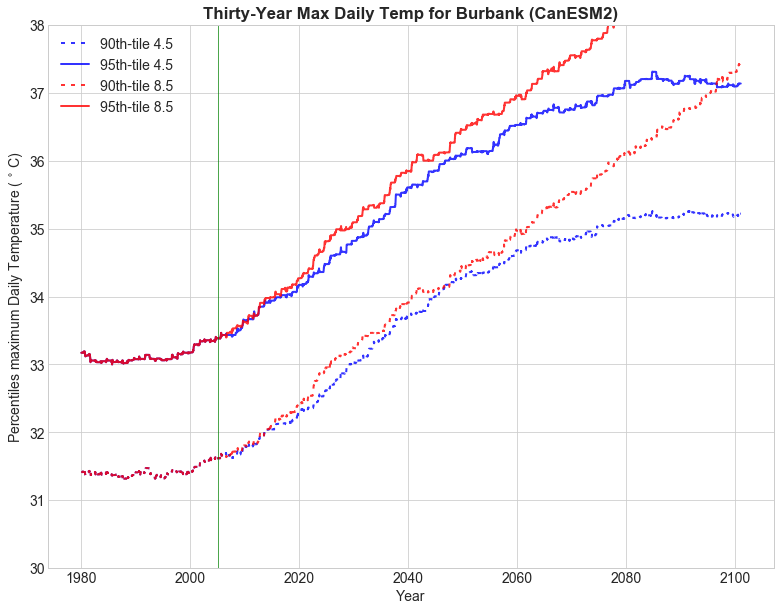

In [40]:

plt.plot(projectedDF.index, canesm45_quant90, color = 'b', ls = 'dashed', alpha = 0.8, dashes=(2, 3), label = '90th-tile 4.5')
plt.plot(projectedDF.index, canesm45_quant95, color = 'b', ls = 'solid', alpha = 0.8, label = '95th-tile 4.5')
plt.plot(projectedDF.index, canesm85_quant90, color = 'r', ls = 'dashed', alpha = 0.8, dashes=(2, 3), label = '90th-tile 8.5')
plt.plot(projectedDF.index, canesm85_quant95, color = 'r', ls = 'solid', alpha = 0.8, label = '95th-tile 8.5')
plt.xlabel('Year')
plt.ylabel('Percentiles maximum Daily Temperature ( $^{\circ}$ C)')
plt.title('Thirty-Year Max Daily Temp for Burbank (CanESM2)', weight = 'bold')
#plt.text(723999, 30.3, 'Historical Simulations', fontsize = 13)
#plt.text(739999, 30.3, 'Projections', fontsize = 13)
plt.legend()
plt.style.use('seaborn-whitegrid')
plt.axvline(x= '2005', alpha = 0.7, color = 'g', linewidth = 1.0)
axes = plt.gca()
axes.set_ylim([30,38])
#plt.rcParams['figure.figsize'] = [13, 18]
plt.savefig('test2.pdf', bbox_inches='tight')

plt.show()

### HadGEM2

In [41]:
hadgem45_quant90 = projectedDF['HadGEM2-ES_rcp45'].rolling(10957).quantile(.90, interpolation='lower')
hadgem45_quant95 = projectedDF['HadGEM2-ES_rcp45'].rolling(10957).quantile(.95, interpolation='lower')
hadgem85_quant90 = projectedDF['HadGEM2-ES_rcp85'].rolling(10957).quantile(.90, interpolation='lower')
hadgem85_quant95 = projectedDF['HadGEM2-ES_rcp85'].rolling(10957).quantile(.95, interpolation='lower')

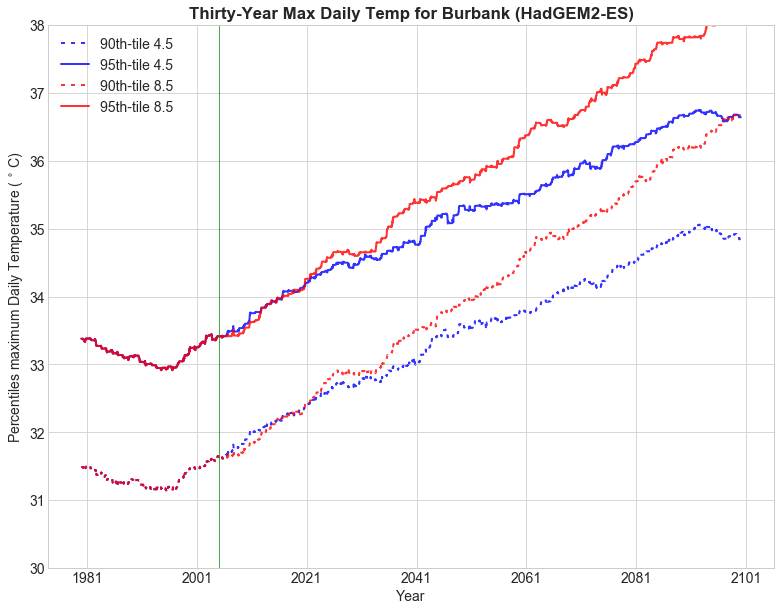

In [42]:
plt.plot(projectedDF.index, hadgem45_quant90, color = 'b', ls = 'dashed', alpha = 0.8, dashes=(2, 3), label = '90th-tile 4.5')
plt.plot(projectedDF.index, hadgem45_quant95, color = 'b', ls = 'solid', alpha = 0.8, label = '95th-tile 4.5')
plt.plot(projectedDF.index, hadgem85_quant90, color = 'r', ls = 'dashed', alpha = 0.8, dashes=(2, 3), label = '90th-tile 8.5')
plt.plot(projectedDF.index, hadgem85_quant95, color = 'r', ls = 'solid', alpha = 0.8, label = '95th-tile 8.5')
plt.axvline(x= '2005', alpha = 0.7, color = 'g', linewidth = 1.0)
plt.xlabel('Year')
plt.ylabel('Percentiles maximum Daily Temperature ( $^{\circ}$ C)')
plt.title('Thirty-Year Max Daily Temp for Burbank (HadGEM2-ES)', weight = 'bold')
plt.legend()
#plt.text(723999, 30.3, 'Historical Simulations', fontsize = 13)
#plt.text(739999, 30.3, 'Projections', fontsize = 13)
sns.set_style("whitegrid")
axes = plt.gca()
axes.set_ylim([30,38])
plt.savefig('test3.pdf', bbox_inches='tight')

plt.show()

### MIROC5

In [43]:
miroc45_quant90 = projectedDF['MIROC5_rcp45'].rolling(10957).quantile(.90, interpolation='lower')
miroc45_quant95 = projectedDF['MIROC5_rcp45'].rolling(10957).quantile(.95, interpolation='lower')
miroc85_quant90 = projectedDF['MIROC5_rcp85'].rolling(10957).quantile(.90, interpolation='lower')
miroc85_quant95 = projectedDF['MIROC5_rcp85'].rolling(10957).quantile(.95, interpolation='lower')

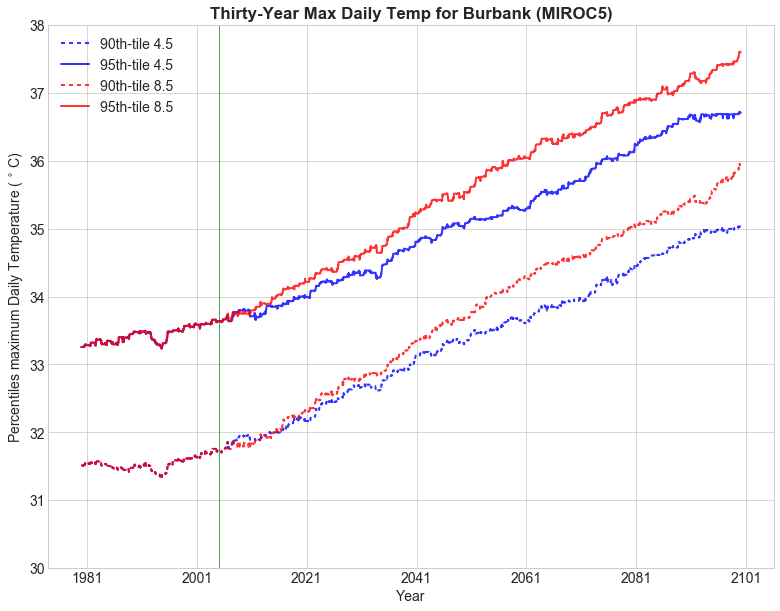

In [44]:
plt.plot(projectedDF.index, miroc45_quant90, color = 'b', ls = 'dashed', alpha = 0.8, dashes=(2, 2), label = '90th-tile 4.5')
plt.plot(projectedDF.index, miroc45_quant95, color = 'b', ls = 'solid', alpha = 0.8, label = '95th-tile 4.5')
plt.plot(projectedDF.index, miroc85_quant90, color = 'r', ls = 'dashed', alpha = 0.8, dashes=(2, 2), label = '90th-tile 8.5')
plt.plot(projectedDF.index, miroc85_quant95, color = 'r', ls = 'solid', alpha = 0.8, label = '95th-tile 8.5')
plt.xlabel('Year')
plt.ylabel('Percentiles maximum Daily Temperature ( $^{\circ}$ C)')
plt.title('Thirty-Year Max Daily Temp for Burbank (MIROC5)', weight = 'bold')
#plt.text(723999, 30.3, 'Historical Simulations', fontsize = 13)
#plt.text(739999, 30.3, 'Projections', fontsize = 13)
plt.axvline(x= '2005', alpha = 0.7, color = 'g', linewidth = 1.0)
plt.legend()
sns.set_style("whitegrid")
axes = plt.gca()
axes.set_ylim([30,38])

plt.savefig('test4.pdf', bbox_inches='tight')
plt.show()